# Mammal Ensemble Language Model

This notebook trains a genomic language model on the data prepared in the __Mammal 0 Genomic Data Processing__ notebook. The model structure and training methodology for genomic language models is explained in the [E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb) notebook.

This notebook is basically a ton of repetitive code because I had to break the training procedure into multiple chunks over several days.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
df_valid = pd.read_csv(path/'mammal_val.csv')

In [6]:
df_iter = pd.read_csv(path/'mammal_train.csv', chunksize=1000000)

In [8]:
df = next(df_iter)

In [9]:
df.head()

,Sequence,Source,set
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human,train
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human,train
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human,train
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human,train
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human,train


In [10]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=4, stride=2), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[:100000], df_valid, bs=800, tokenizer=tok, 
                              chunksize=10000, text_cols=0, label_cols=1, max_vocab=80000)

In [12]:
len(data.vocab.stoi), len(data.vocab.itos)

(257, 257)

In [13]:
np.save(path/'mammal_vocab_4mer.npy', data.vocab.itos)

In [14]:
voc = np.load(path/'mammal_vocab_4mer.npy')
model_vocab = GenomicVocab(voc)

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[100000], df_valid, bs=800, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                              chunksize=10000, text_cols=0, label_cols=1)

In [ ]:
len(data.vocab.itos), len(data.vocab.stoi)

In [17]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult=0.3

In [18]:
learn = get_model_LM(data, drop_mult, config)

In [19]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(257, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(257, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=257, bias=True)
    (output_dp): RNNDropout()
  )
)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


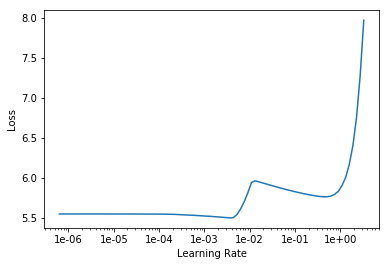

In [23]:
learn.recorder.plot()

0 - 1,000,000

In [24]:
count = 0
lr = 5e-3

dfs = [df[i:i+250000] for i in range(0, len(df), 250000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=10000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.005


epoch,train_loss,valid_loss,accuracy,time
0,2.284353,2.241887,0.279166,47:46


Learning Rate: 0.0033333333333333335


epoch,train_loss,valid_loss,accuracy,time
0,2.217593,2.182229,0.301032,47:42


Learning Rate: 0.0022222222222222222


epoch,train_loss,valid_loss,accuracy,time
0,2.220641,2.169917,0.305230,47:45


Learning Rate: 0.0014814814814814814


epoch,train_loss,valid_loss,accuracy,time
0,2.191864,2.160409,0.308593,47:41


In [25]:
learn.save('mammal_4mer')
learn.save('mammal_4mer_enc')

1,000,000 - 2,000,000

In [26]:
df = next(df_iter)

In [27]:
df.head()

,Sequence,Source,set
1000000,CATTGTTTTCATTCTCCATGACCGCTGTGGGTCACTTTCTATTATT...,NCBI Human,train
1000001,CACTTCAAAATGAAAAAATAATTATTGGAACTACATTGGGGGAACT...,NCBI Human,train
1000002,CAGTACAGCAGAATTCAAGGTCAGGGTAATTGCTTTCAGACAATAC...,NCBI Human,train
1000003,GATGGGGAAGAGTCAAGAACAGACAGCAGACGAGAAAAATAAATGA...,NCBI Human,train
1000004,AAGTAAATTGAAAACCTAGACAAGATTTTCCATTCTAGATGCCATT...,NCBI Human,train


In [28]:
count = 0
lr = 3e-3

dfs = [df[i:i+250000] for i in range(0, len(df), 250000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=10000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.003


epoch,train_loss,valid_loss,accuracy,time
0,2.152615,2.154483,0.310850,47:42


Learning Rate: 0.002


epoch,train_loss,valid_loss,accuracy,time
0,2.129203,2.143165,0.314794,47:25


Learning Rate: 0.0013333333333333333


epoch,train_loss,valid_loss,accuracy,time
0,2.231328,2.141964,0.315378,47:41


Learning Rate: 0.0008888888888888889


epoch,train_loss,valid_loss,accuracy,time
0,2.232863,2.139719,0.316122,47:42


In [29]:
learn.save('mammal_4mer')
learn.save('mammal_4mer_enc')

2,000,000 - 3,000,000

In [30]:
df = next(df_iter)

In [31]:
df.head()

,Sequence,Source,set
2000000,CCCGGCAAGTGTTGCCAGTTTGAGGATGAGCATATGTCCTCAGTAG...,NCBI Pan Troglodytes,train
2000001,TCTACCCAAATCCTATAAAACGGCCCCACCCTTATCTCCCTTCGCT...,NCBI Pan Troglodytes,train
2000002,GAGGAGAGGTTTGTGAATAGCAGGAAGTAAGGTTAGGGCCAAAGAT...,NCBI Pan Troglodytes,train
2000003,GCCAGTCTCACTGATTTTCTTGAAACAAATTTCTTCCTTGACGATC...,NCBI Pan Troglodytes,train
2000004,TTCTTTTTGTTCCCCTGATCTCACCATAAGCATGTAGTCTTCTAAA...,NCBI Pan Troglodytes,train


In [32]:
count = 0
lr = 3e-3

dfs = [df[i:i+250000] for i in range(0, len(df), 250000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=10000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.003


epoch,train_loss,valid_loss,accuracy,time
0,2.223187,2.131859,0.319124,47:49


Learning Rate: 0.002


epoch,train_loss,valid_loss,accuracy,time
0,2.236457,2.132198,0.319068,47:39


Learning Rate: 0.0013333333333333333


epoch,train_loss,valid_loss,accuracy,time
0,2.189953,2.127684,0.320707,47:49


Learning Rate: 0.0008888888888888889


epoch,train_loss,valid_loss,accuracy,time
0,2.237300,2.123286,0.322396,47:43


In [33]:
learn.save('mammal_4mer')
learn.save('mammal_4mer_enc')

3,000,000 - 4,000,000

In [34]:
df = next(df_iter)

In [35]:
df.head()

,Sequence,Source,set
3000000,GTACACACGGGGGCCTGTTAAAAGATCAGGGGTGGGAGGAGGGAGA...,NCBI Pan paniscus,train
3000001,GGGTTTATGTTTGAGGATGATTCTCTTTCTTGTCACCTTGGTGAGT...,NCBI Pan paniscus,train
3000002,TGCAACAGCTGTTAGGCACAGACTTGACTTTCAGGTTGTACAACGG...,NCBI Pan paniscus,train
3000003,TGCATAAACAATTCTTACATGAATAAATGGACACTTGTGCAGTGCA...,NCBI Pan paniscus,train
3000004,TATTTTGACTATGGAGTGCCCATTTAAATATCGTATTTCTTTCTTA...,NCBI Pan paniscus,train


In [36]:
count = 0
lr = 1e-3

dfs = [df[i:i+250000] for i in range(0, len(df), 250000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=10000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.001


epoch,train_loss,valid_loss,accuracy,time
0,2.248635,2.118819,0.323942,47:23


Learning Rate: 0.0006666666666666666


epoch,train_loss,valid_loss,accuracy,time
0,2.250747,2.116734,0.324790,47:37


Learning Rate: 0.00044444444444444447


epoch,train_loss,valid_loss,accuracy,time
0,2.222938,2.113486,0.326045,47:42


Learning Rate: 0.0002962962962962963


epoch,train_loss,valid_loss,accuracy,time
0,2.264197,2.112846,0.326395,47:40


In [37]:
learn.save('mammal_4mer')
learn.save('mammal_4mer_enc')

4,000,000 - 4,713,593

In [38]:
df = next(df_iter)

In [39]:
df.head()

,Sequence,Source,set
4000000,TTCAAAACATATCTAGTGAGCACATATTATGTAACAGGCTCAAAGG...,NCBI Gorilla gorilla gorilla,train
4000001,CCACCTAGTGGTCAAGTTTAGCAAAACTTTCTGGAGTCTATTGTTT...,NCBI Gorilla gorilla gorilla,train
4000002,CTCACACTGAAAATCATCATCAAAATGCAACATAATAATTATCTTC...,NCBI Gorilla gorilla gorilla,train
4000003,TTGTCAGCACACAGCGGTATCCAAGGTGCCTGGACTCTGTCAGGTT...,NCBI Gorilla gorilla gorilla,train
4000004,GTGGTTTGTAGTTCTCCTTGAAGAGGTCCTTCACGTCCCTTGTAAG...,NCBI Gorilla gorilla gorilla,train


In [40]:
count = 0
lr = 1e-3

dfs = [df[i:i+250000] for i in range(0, len(df), 250000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=10000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.001


epoch,train_loss,valid_loss,accuracy,time
0,2.255818,2.112192,0.326684,47:41


Learning Rate: 0.0006666666666666666


epoch,train_loss,valid_loss,accuracy,time
0,2.258950,2.110102,0.327586,47:42


Learning Rate: 0.00044444444444444447


epoch,train_loss,valid_loss,accuracy,time
0,2.226669,2.106663,0.328850,41:12


In [41]:
learn.save('mammal_4mer')
learn.save('mammal_4mer_enc')